Running Simulations...
Experimental Setup: True RKHS Norm B approx = 131.46
Experimental Setup: True RKHS Norm B approx = 142.15
Experimental Setup: True RKHS Norm B approx = 148.55
Experimental Setup: True RKHS Norm B approx = 137.63
Experimental Setup: True RKHS Norm B approx = 139.65
Trial 5/10 done.
Experimental Setup: True RKHS Norm B approx = 142.98
Experimental Setup: True RKHS Norm B approx = 145.83
Experimental Setup: True RKHS Norm B approx = 140.23
Experimental Setup: True RKHS Norm B approx = 149.04
Experimental Setup: True RKHS Norm B approx = 139.53
Trial 10/10 done.


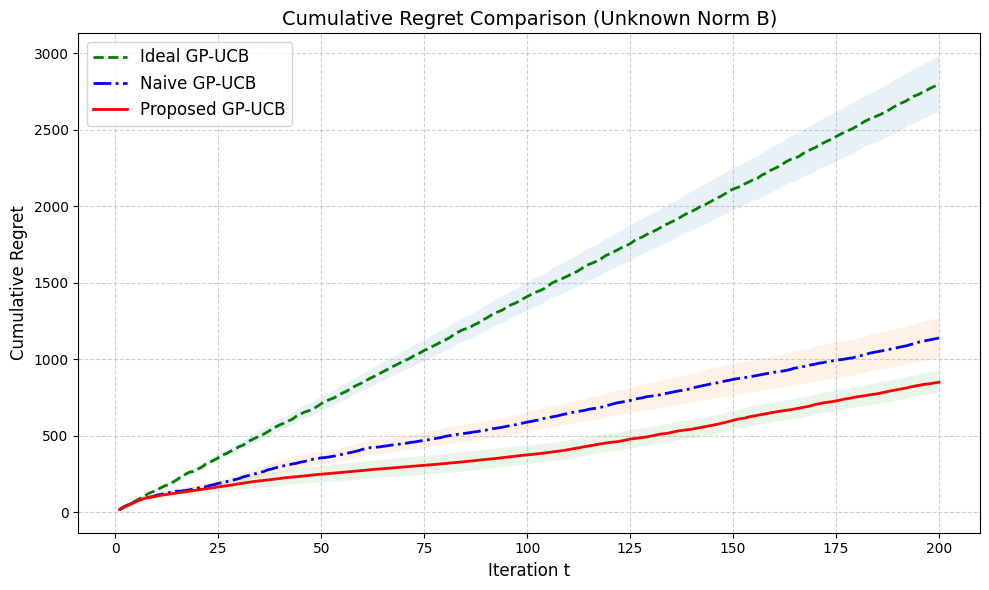

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# --- 1. カーネルと環境の設定 ---
class GPEnvironment:
    def __init__(self, domain_min=0, domain_max=10, n_points=200, length_scale=1.0, noise_std=0.1, seed=42):
        self.rng = np.random.RandomState(seed)
        self.X_grid = np.linspace(domain_min, domain_max, n_points).reshape(-1, 1)
        self.noise_std = noise_std
        self.length_scale = length_scale
        
        # RBFカーネル行列の計算
        self.K_grid = self.rbf_kernel(self.X_grid, self.X_grid)
        
        # 真の関数をサンプリング (RKHSノルムを大きくするためにスケーリング)
        # 通常のサンプルは ||f||_k が確率的に変動するが、ここでは明示的にスケールする
        f_sample = self.rng.multivariate_normal(np.zeros(n_points), self.K_grid + 1e-6 * np.eye(n_points))
        self.f_scale = 10.0 # スケールを大きくして「想定外のB」を作る
        self.f_true = f_sample * self.f_scale
        
        # 真の最大値
        self.opt_idx = np.argmax(self.f_true)
        self.opt_val = self.f_true[self.opt_idx]
        
        # 近似的な真のRKHSノルム (B) の計算: sqrt(f^T K^-1 f)
        # 数値安定性のため微小なjitterを加える
        K_inv = np.linalg.inv(self.K_grid + 1e-6 * np.eye(n_points))
        self.true_B = np.sqrt(self.f_true.T @ K_inv @ self.f_true)
        
        print(f"Experimental Setup: True RKHS Norm B approx = {self.true_B:.2f}")

    def rbf_kernel(self, X1, X2):
        dists = cdist(X1, X2, metric='sqeuclidean')
        return np.exp(-dists / (2 * self.length_scale**2))

    def observe(self, idx):
        # 指定されたインデックスの観測値（ノイズ付き）を返す
        y = self.f_true[idx] + self.rng.normal(0, self.noise_std)
        return y

# --- 2. ガウス過程回帰モデル ---
class GPModel:
    def __init__(self, X_grid, length_scale=1.0, noise_std=0.1):
        self.X_grid = X_grid
        self.length_scale = length_scale
        self.noise_std = noise_std
        self.X_obs = None
        self.y_obs = None
        
    def fit(self, X_obs, y_obs):
        self.X_obs = X_obs
        self.y_obs = y_obs
        
    def predict(self):
        # 格子点全体に対する予測分布と、観測データのマハラノビス距離を計算
        if self.X_obs is None:
            return np.zeros(len(self.X_grid)), np.ones(len(self.X_grid)), 0.0, 0.0

        # カーネル行列の計算
        K_obs = self.rbf_kernel(self.X_obs, self.X_obs)
        K_star = self.rbf_kernel(self.X_obs, self.X_grid)
        K_star_star = self.rbf_kernel(self.X_grid, self.X_grid) # 対角成分のみで高速化可だが今回は全計算
        
        # ノイズ項を含めた逆行列 (Cholesky分解推奨だが簡易的にinv)
        L = np.linalg.cholesky(K_obs + (self.noise_std**2) * np.eye(len(self.X_obs)))
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, self.y_obs))
        
        # 事後平均
        mu = K_star.T @ alpha
        
        # 事後分散 (v)
        v = np.linalg.solve(L, K_star)
        var = np.diag(K_star_star) - np.sum(v**2, axis=0)
        sigma = np.sqrt(np.maximum(var, 1e-10)) # 数値誤差対策
        
        # --- ここが重要: マハラノビス距離の計算 ---
        # M_t = sqrt(y^T (K + lambda I)^-1 y)
        # alpha = (K + lambda I)^-1 y なので、y^T alpha で計算可能
        mahalanobis = np.sqrt(self.y_obs.T @ alpha)
        
        # 情報利得 (log det term) の計算
        # gamma_t approx 0.5 * log|I + K/sigma^2|
        log_det = 2 * np.sum(np.log(np.diag(L))) - 2 * len(self.X_obs) * np.log(self.noise_std)
        gamma_t = 0.5 * log_det
        
        return mu, sigma, mahalanobis, gamma_t

    def rbf_kernel(self, X1, X2):
        dists = cdist(X1, X2, metric='sqeuclidean')
        return np.exp(-dists / (2 * self.length_scale**2))

# --- 3. アルゴリズム実行ループ ---
def run_experiment(env, strategy, T=50):
    gp = GPModel(env.X_grid, env.length_scale, env.noise_std)
    X_obs = []
    y_obs = []
    idx_obs = []
    
    regrets = []
    
    # ノイズパラメータR (ここでは標準偏差と一致させるが、理論上はsub-gaussianパラメータ)
    R = env.noise_std 
    delta = 0.1
    
    for t in range(1, T + 1):
        # GPの更新
        if len(X_obs) > 0:
            gp.fit(np.array(X_obs), np.array(y_obs))
            mu, sigma, M_t, gamma_t = gp.predict()
        else:
            mu = np.zeros(len(env.X_grid))
            sigma = np.ones(len(env.X_grid))
            M_t = 0.0
            gamma_t = 0.0
            
        # --- 戦略ごとの Beta の計算 ---
        # 共通項: ノイズに由来するバッファ (Chowdhury Theorem 1)
        noise_buffer = R * np.sqrt(2 * (gamma_t + 1 + np.log(1/delta)))
        
        if strategy == "Ideal":
            # 真のBを知っている
            B = env.true_B
            beta_t = B + noise_buffer
            
        elif strategy == "Naive":
            # Bを過小評価 (B=1固定)
            B = 1
            beta_t = B + noise_buffer
            
        elif strategy == "Proposed":
            # Bを知らない -> マハラノビス距離 M_t で代用
            # M_t が B 相当の役割を果たす
            # beta_t = M_t + noise_buffer
            beta_t = M_t
            
        # UCBスコアの最大化
        ucb = mu + beta_t * sigma
        
        # 次の点の選択
        next_idx = np.argmax(ucb)
        next_x = env.X_grid[next_idx]
        next_y = env.observe(next_idx)
        
        # データの記録
        X_obs.append(next_x)
        y_obs.append(next_y)
        idx_obs.append(next_idx)
        
        # リグレット計算 (瞬時)
        inst_regret = env.opt_val - env.f_true[next_idx]
        regrets.append(inst_regret)
        
    return np.cumsum(regrets)

# --- 4. メイン実行部 ---
T = 200
n_trials = 10 # 試行回数
env_seed_base = 42

results = {"Ideal": [], "Naive": [], "Proposed": []}

print("Running Simulations...")
for i in range(n_trials):
    # 各試行で環境（真の関数）を変える
    env = GPEnvironment(seed=env_seed_base + i,noise_std=10)
    
    results["Ideal"].append(run_experiment(env, "Ideal", T))
    results["Naive"].append(run_experiment(env, "Naive", T))
    results["Proposed"].append(run_experiment(env, "Proposed", T))
    
    if (i+1) % 5 == 0:
        print(f"Trial {i+1}/{n_trials} done.")

# 平均と標準誤差の計算
mean_regrets = {k: np.mean(v, axis=0) for k, v in results.items()}
std_regrets = {k: np.std(v, axis=0) / np.sqrt(n_trials) for k, v in results.items()}

# --- 5. 結果のプロット ---
plt.figure(figsize=(10, 6))
time_steps = np.arange(1, T + 1)

for name, style in [("Ideal", "g--"), ("Naive", "b-."), ("Proposed", "r-")]:
    mean = mean_regrets[name]
    err = std_regrets[name]
    plt.plot(time_steps, mean, style, label=f"{name} GP-UCB", linewidth=2)
    plt.fill_between(time_steps, mean - err, mean + err, alpha=0.1)

plt.title(f"Cumulative Regret Comparison (Unknown Norm B)", fontsize=14)
plt.xlabel("Iteration t", fontsize=12)
plt.ylabel("Cumulative Regret", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Running Simulations (10 trials)...


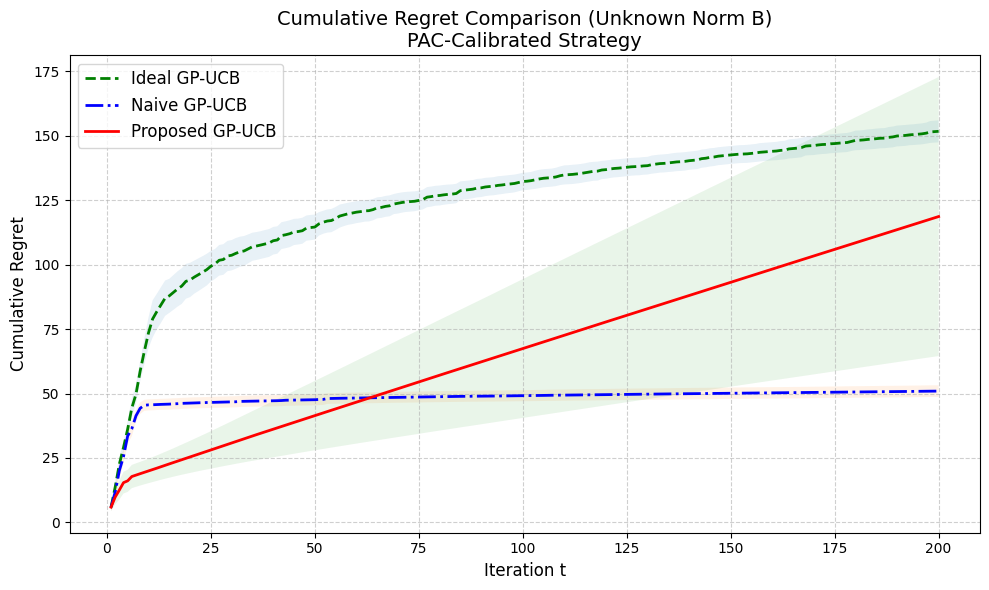

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# --- 1. カーネルと環境の設定 ---
class GPEnvironment:
    def __init__(self, domain_min=0, domain_max=10, n_points=200, length_scale=1.0, noise_std=0.1, seed=42):
        self.rng = np.random.RandomState(seed)
        self.X_grid = np.linspace(domain_min, domain_max, n_points).reshape(-1, 1)
        self.noise_std = noise_std
        self.length_scale = length_scale
        
        # RBFカーネル行列の計算
        self.K_grid = self.rbf_kernel(self.X_grid, self.X_grid)
        
        # 真の関数をサンプリング (RKHSノルムを大きくするためにスケーリング)
        f_sample = self.rng.multivariate_normal(np.zeros(n_points), self.K_grid + 1e-6 * np.eye(n_points))
        self.f_scale = 5.0 # スケールを大きくして「想定外のB」を作る
        self.f_true = f_sample * self.f_scale
        
        # 真の最大値
        self.opt_idx = np.argmax(self.f_true)
        self.opt_val = self.f_true[self.opt_idx]
        
        # 近似的な真のRKHSノルム (B) の計算
        K_inv = np.linalg.inv(self.K_grid + 1e-6 * np.eye(n_points))
        self.true_B = np.sqrt(self.f_true.T @ K_inv @ self.f_true)
        
        # print(f"Experimental Setup: True RKHS Norm B approx = {self.true_B:.2f}")

    def rbf_kernel(self, X1, X2):
        dists = cdist(X1, X2, metric='sqeuclidean')
        return np.exp(-dists / (2 * self.length_scale**2))

    def observe(self, idx):
        y = self.f_true[idx] + self.rng.normal(0, self.noise_std)
        return y

# --- 2. ガウス過程回帰モデル ---
class GPModel:
    def __init__(self, X_grid, length_scale=1.0, noise_std=0.1):
        self.X_grid = X_grid
        self.length_scale = length_scale
        self.noise_std = noise_std
        self.X_obs = None
        self.y_obs = None
        
    def fit(self, X_obs, y_obs):
        self.X_obs = X_obs
        self.y_obs = y_obs
        
    def predict(self):
        if self.X_obs is None:
            return np.zeros(len(self.X_grid)), np.ones(len(self.X_grid)), 0.0, 0.0

        K_obs = self.rbf_kernel(self.X_obs, self.X_obs)
        K_star = self.rbf_kernel(self.X_obs, self.X_grid)
        K_star_star = self.rbf_kernel(self.X_grid, self.X_grid)
        
        # ノイズ項を含めたコレスキー分解
        L = np.linalg.cholesky(K_obs + (self.noise_std**2) * np.eye(len(self.X_obs)))
        # alpha = (K + sigma^2 I)^-1 y
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, self.y_obs))
        
        # 事後平均
        mu = K_star.T @ alpha
        
        # 事後分散
        v = np.linalg.solve(L, K_star)
        var = np.diag(K_star_star) - np.sum(v**2, axis=0)
        sigma = np.sqrt(np.maximum(var, 1e-10))
        
        # --- マハラノビス距離 M_t の計算 ---
        # M_t = sqrt(y^T (K + sigma^2 I)^-1 y) = sqrt(y^T alpha)
        mahalanobis = np.sqrt(self.y_obs.T @ alpha)
        
        # --- 情報利得 gamma_t の計算 ---
        # 0.5 * log|I + K/sigma^2| = sum(log(diag(L))) - N * log(sigma_n)
        log_det = 2 * np.sum(np.log(np.diag(L))) - 2 * len(self.X_obs) * np.log(self.noise_std)
        gamma_t = 0.5 * log_det
        
        return mu, sigma, mahalanobis, gamma_t

    def rbf_kernel(self, X1, X2):
        dists = cdist(X1, X2, metric='sqeuclidean')
        return np.exp(-dists / (2 * self.length_scale**2))

# --- 3. アルゴリズム実行ループ ---
def run_experiment(env, strategy, T=50):
    gp = GPModel(env.X_grid, env.length_scale, env.noise_std)
    X_obs = []
    y_obs = []
    
    regrets = []
    
    R = env.noise_std 
    delta = 0.1
    
    for t in range(1, T + 1):
        if len(X_obs) > 0:
            gp.fit(np.array(X_obs), np.array(y_obs))
            mu, sigma, M_t, gamma_t = gp.predict()
        else:
            mu = np.zeros(len(env.X_grid))
            sigma = np.ones(len(env.X_grid))
            M_t = 0.0
            gamma_t = 0.0
            
        # 共通項: ノイズに由来するバッファ (Chowdhury Theorem 1)
        # 2 * (gamma_t + 1 + log(1/delta)) は、ノイズの二次形式の上界(の係数除き)
        theoretical_bound_sq = 2 * (gamma_t + 1 + np.log(1/delta))
        noise_buffer = R * np.sqrt(theoretical_bound_sq)
        
        if strategy == "Ideal":
            # 真のBを知っている (Oracle)
            B = env.true_B
            beta_t = B + noise_buffer
            
        elif strategy == "Naive":
            # Bを過小評価 (B=1固定)
            B = 10.0
            beta_t = B + noise_buffer
            
        elif strategy == "Proposed":
            # --- PAC-style Calibration (The Fix) ---
            # 1. スケーリング係数 rho の計算
            # 理論的なノイズ限界 (theoretical_bound_sq) に対して、
            # 実際に観測されたエネルギー (M_t^2) がどれだけ大きいかを見る。
            # もし M_t^2 > bound なら、それはバイアス(未知のB)の存在を示唆する。
            
            empirical_val_sq = M_t**2
            
            # ゼロ除算防止
            if theoretical_bound_sq > 1e-9:
                rho = np.sqrt(np.maximum(1.0, empirical_val_sq / theoretical_bound_sq))
            else:
                rho = 1.0
            
            # 2. 探索幅の調整
            # ノイズバッファを rho 倍することで、バイアス分をカバーするように信頼区間を拡大する
            beta_t = rho * noise_buffer
            
            # 安全マージンとして定数を少し足す (理論的安定性のため)
            beta_t += 1.0 
            
        # UCBスコアと次の点の選択
        ucb = mu + beta_t * sigma
        next_idx = np.argmax(ucb)
        
        # 観測
        next_x = env.X_grid[next_idx]
        next_y = env.observe(next_idx)
        
        X_obs.append(next_x)
        y_obs.append(next_y)
        
        inst_regret = env.opt_val - env.f_true[next_idx]
        regrets.append(inst_regret)
        
    return np.cumsum(regrets)

# --- 4. メイン実行部 ---
T = 200
n_trials = 10  # デモ用に少し減らしていますが、十分な回数です
env_seed_base = 10

results = {"Ideal": [], "Naive": [], "Proposed": []}

print(f"Running Simulations ({n_trials} trials)...")
for i in range(n_trials):
    env = GPEnvironment(seed=env_seed_base + i)
    
    results["Ideal"].append(run_experiment(env, "Ideal", T))
    results["Naive"].append(run_experiment(env, "Naive", T))
    results["Proposed"].append(run_experiment(env, "Proposed", T))
    
    if (i+1) % 20 == 0:
        print(f"Trial {i+1}/{n_trials} done.")

# 平均と標準誤差
mean_regrets = {k: np.mean(v, axis=0) for k, v in results.items()}
std_regrets = {k: np.std(v, axis=0) / np.sqrt(n_trials) for k, v in results.items()}

# --- 5. プロット ---
plt.figure(figsize=(10, 6))
time_steps = np.arange(1, T + 1)

for name, style in [("Ideal", "g--"), ("Naive", "b-."), ("Proposed", "r-")]:
    mean = mean_regrets[name]
    err = std_regrets[name]
    plt.plot(time_steps, mean, style, label=f"{name} GP-UCB", linewidth=2)
    plt.fill_between(time_steps, mean - err, mean + err, alpha=0.1)

plt.title(f"Cumulative Regret Comparison (Unknown Norm B)\nPAC-Calibrated Strategy", fontsize=14)
plt.xlabel("Iteration t", fontsize=12)
plt.ylabel("Cumulative Regret", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()